In [94]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
import plotly.express as px
from plotly.graph_objects import Table
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.layers import LSTM

# **1- Dataset Loading**

In [114]:
df = pd.read_csv("BTC-USD.csv")

In [115]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [116]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [117]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

**Columns	Description :**

**Open:**	The price of Bitcoin at the beginning of the trading day.

**High:**	The highest price reached during the trading day.

**Low:**	The lowest price reached during the trading day.

**Close:**	The final price of Bitcoin at the end of the trading day.

**Volume:**	The total number of Bitcoins traded during that day (may be in USD volume or BTC units depending on source)

# **2- EDA**

In [118]:
for col in ['Open', 'High', 'Low', 'Close']:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Date'], y=df[col], mode='lines', name=col))
    fig.update_layout(
        title=f"Bitcoin {col} Price Over Time",
        xaxis_title="Date",
        yaxis_title=f"{col} Price (USD)"
    )
    fig.show()

![OPEN](rnn_images/newplot.png)
![HIGH-PRICE](rnn_images/newplot%20(2).png)
![LOW-PRICE](rnn_images/newplot%20(3).png)
![CLOSE](rnn_images/newplot%20(4).png)

The four plots of Bitcoin's Open, High, Low, and Close prices show consistent trends, reflecting the same underlying asset's price movements. Bitcoin experienced a period of relative stability from 2015 to late 2017, followed by a significant bull run in late 2017 to early 2018, peaking around $20,000.

After a correction in 2018, there was a gradual growth and consolidation phase through 2019 and 2020. The most dramatic period was the explosive bull market in 2021-2022, reaching nearly $70,000, which was then followed by a substantial correction. More recently, late 2022 into 2023 shows a period of stabilization and modest recovery. Overall, the plots illustrate Bitcoin's volatile history, marked by distinct cycles of growth, correction, and recovery.

In [119]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Volume'], mode='lines', name='Volume', line=dict(color='orange')))
fig.update_layout(title="Bitcoin Volume Over Time", xaxis_title="Date", yaxis_title="Volume")
fig.show()

![VOLUME](rnn_images/newplot%20(1).png)

The Bitcoin volume chart shows low trading activity in early years (2015-2017), followed by significant spikes in volume during major price rallies (late 2017-early 2018 and especially 2021). Volume generally decreased during bear markets (2022) and has seen moderate increases with recent price recovery (late 2022-2023)

This indicates that high volume confirms strong market interest and price movements, while lower volume suggests reduced participation.

In [121]:
corr_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title='Correlation Heatmap of OHLCV Features'
)
fig.show()

![CORR](rnn_images/newplot%20(5).png)

In [122]:
summary_stats = df[['Open', 'High', 'Low', 'Close', 'Volume']].describe().round(2)
fig = go.Figure(data=[Table(
    header=dict(values=["Stat"] + list(summary_stats.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[summary_stats.index] + [summary_stats[col].values for col in summary_stats.columns],
               fill_color='lavender',
               align='left'))
])
fig.update_layout(title="Statistical Summary of OHLCV")
fig.show()


![STATISTICS](rnn_images/newplot%20(6).png)

# **3- Data Processing:**

## **Handle Missing Data**

In [ ]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [124]:
df_melted = df[["Open", "High", "Low", "Close"]].melt( var_name='Feature', value_name='Value')

fig = px.box(df_melted, x='Feature', y='Value', points='all', title="Outliers in OHLCV Features (IQR Method)")
fig.show()

![BOX_PLOT](rnn_images/newplot%20(7).png)

In [126]:
fig = px.box(df, y='Volume', points='all', title="Box Plot of Bitcoin Trading Volume (Outliers Highlighted)")
fig.show()

![BOX_PLOT2](rnn_images/newplot%20(8).png)

In [127]:
df = df[df['Volume'] < df['Volume'].quantile(0.99)]

## **Normalization:**

In [128]:
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[["Open", "High", "Low", "Close", "Volume"]])
df[["Open", "High", "Low", "Close", "Volume"]] = pd.DataFrame(scaled_values, index=df.index, columns=["Open", "High", "Low", "Close", "Volume"])

In [102]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2014-09-17,0.004289,0.003739,0.004243,0.004144,0.000200
1,2014-09-18,0.004155,0.003574,0.003649,0.003655,0.000378
2,2014-09-19,0.003669,0.003151,0.003217,0.003216,0.000423
3,2014-09-20,0.003232,0.003085,0.003298,0.003425,0.000409
4,2014-09-21,0.003431,0.002927,0.003348,0.003275,0.000273


# **Define Target:**

In [103]:
df['Target'] = (df['Close'].shift(-3) - df['Close']) / df['Close']
df['Target'] = (df['Target'] > 0).astype(int)
df.head()

,Date,Open,High,Low,Close,Volume,Target
0,2014-09-17,0.004289,0.003739,0.004243,0.004144,0.000200,0
1,2014-09-18,0.004155,0.003574,0.003649,0.003655,0.000378,0
2,2014-09-19,0.003669,0.003151,0.003217,0.003216,0.000423,1
3,2014-09-20,0.003232,0.003085,0.003298,0.003425,0.000409,1
4,2014-09-21,0.003431,0.002927,0.003348,0.003275,0.000273,1


In [104]:
df['Target'].value_counts()

,count
Target,
1,1738
0,1451


# **Sequence Creation And Lookback Period:**

In [106]:
def create_sequences(data, target, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(target[i+lookback])
    return np.array(X), np.array(y)

lookback = 30
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
target = df['Target'].values

X, y = create_sequences(features, target, lookback)

# **Split the dataset into training, validation, and test sets:**

In [108]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

| Validation Set                                                            | Test Set                                                                  |
| ------------------------------------------------------------------------- | ------------------------------------------------------------------------- |
| Used during training to **tune hyperparameters** and pick the best model  | Used **only once** after training to evaluate **final model performance** |
| Helps prevent overfitting to training data                                | Provides an **unbiased estimate** of generalization                       |
| Can be used for **early stopping**, learning rate tuning, lookback tuning | Should never influence training decisions                                 |


# **4- Model Architecture:**

# **Simple RNN**

In [64]:
model = Sequential([
    SimpleRNN(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    BatchNormalization(),

    SimpleRNN(128, return_sequences=True),

    SimpleRNN(64, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    SimpleRNN(32),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1)
])

model.summary()

model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='mse',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_16 (SimpleRNN)       │ (None, 30, 512)        │       265,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 30, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_18 (SimpleRNN)       │ (None, 30, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_19 (SimpleRNN)       │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366,945 (1.40 MB)

 Trainable params: 366,945 (1.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 0.5087 - loss: 0.4756 - val_accuracy: 0.4557 - val_loss: 0.2976
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.5496 - loss: 0.2535 - val_accuracy: 0.4620 - val_loss: 0.2522
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 0.5096 - loss: 0.2591 - val_accuracy: 0.5696 - val_loss: 0.2444
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.4998 - loss: 0.2558 - val_accuracy: 0.5696 - val_loss: 0.2446
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.5339 - loss: 0.2497 - val_accuracy: 0.4620 - val_loss: 0.2531
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5223 - loss: 0.2524 - val_accuracy: 0.5380 - val_loss: 0.2481
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.5007 - loss: 0.2548 - val_accuracy: 0.5717 - val_loss: 0.2453
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.5541 - loss: 0.2497 - val_accuracy

In [68]:
model = Sequential()
model.add(SimpleRNN(512, return_sequences=False,
               kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=20, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5446 - loss: 1.3466 - val_accuracy: 0.5401 - val_loss: 1.2387
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5414 - loss: 1.2095 - val_accuracy: 0.5148 - val_loss: 1.1617
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.5272 - loss: 1.1240 - val_accuracy: 0.4873 - val_loss: 1.1067
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5437 - loss: 1.0522 - val_accuracy: 0.5274 - val_loss: 1.0036
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.5408 - loss: 0.9870 - val_accuracy: 0.5148 - val_loss: 0.9524
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.5296 - loss: 0.9367 - val_accuracy: 0.5401 - val_loss: 0.9061
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5634 - loss: 0.8919 - val_accuracy: 0.5253 - val_loss: 0.8687
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.5678 - loss: 0.8516 - v

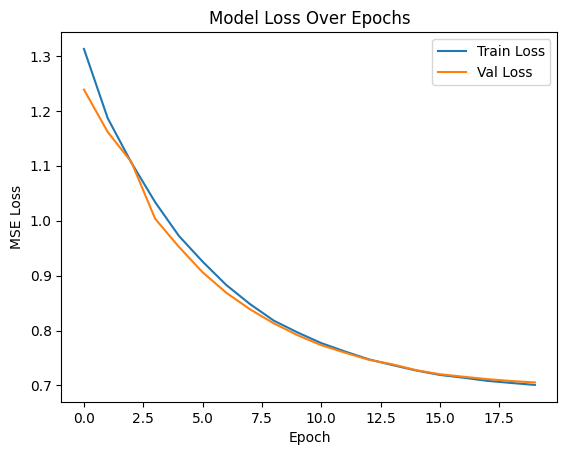

In [132]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [133]:
y_pred = model.predict(X_test).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)

ce = np.sum(y_test - y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Cumulative Error (CE): {ce:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Mean Squared Error (MSE): 0.4873
Root Mean Squared Error (RMSE): 0.6981
Mean Absolute Error (MAE): 0.4873
Mean Absolute Percentage Error (MAPE): 48.73%
Cumulative Error (CE): 231.0000


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Predicted vs Actual Bitcoin Target Value")
plt.xlabel("Time Step")
plt.ylabel("Target")
plt.legend()
plt.show()

# **LSTM Model**

In [151]:
model_LSTM = Sequential([
    LSTM(512, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),

    LSTM(128, return_sequences=True),

    LSTM(64, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),

    LSTM(32),
    Dropout(0.2),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),

    Dense(1)
])

model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

model_LSTM.summary()

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3, restore_best_weights=True)

history_LSTM = model_LSTM.fit(X_train, y_train,
                    epochs=20, batch_size=16,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


loss, accuracy = model_LSTM.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                  │ (None, 30, 512)        │     1,060,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 30, 128)        │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,455,489 (5.55 MB)

 Trainable params: 1,455,297 (5.55 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 362ms/step - accuracy: 0.5145 - loss: 3.2151 - val_accuracy: 0.4620 - val_loss: 0.7626
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 360ms/step - accuracy: 0.4968 - loss: 1.3187 - val_accuracy: 0.5127 - val_loss: 7.8550
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 362ms/step - accuracy: 0.4890 - loss: 1.2995 - val_accuracy: 0.4873 - val_loss: 0.8688
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 358ms/step - accuracy: 0.5102 - loss: 1.0184 - val_accuracy: 0.5127 - val_loss: 0.7085
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 350ms/step - accuracy: 0.5060 - loss: 0.9314 - val_accuracy: 0.4873 - val_loss: 0.7098
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 83s 361ms/step - accuracy: 0.5062 - loss: 0.8456 - val_accuracy: 0.5127 - val_loss: 0.6929
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 351ms/step - accuracy: 0.5122 - loss: 0.7767 - val_accuracy: 0.5127 - val_loss: 1.1306
Epoch 8/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 351ms/step - accuracy: 0.5090 - loss: 0

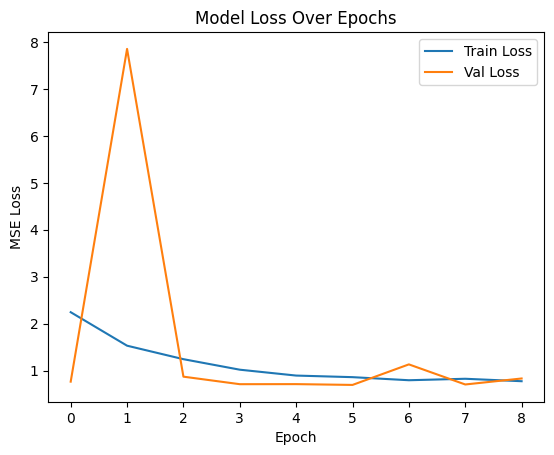

In [152]:
plt.plot(history_LSTM.history['loss'], label='Train Loss')
plt.plot(history_LSTM.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [149]:
y_pred = model.predict(X_test).flatten()
y_pred = np.where(y_pred > 0.5, 1, 0)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred)

ce = np.sum(y_test - y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
print(f"Cumulative Error (CE): {ce:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Mean Squared Error (MSE): 0.4873
Root Mean Squared Error (RMSE): 0.6981
Mean Absolute Error (MAE): 0.4873
Mean Absolute Percentage Error (MAPE): 48.73%
Cumulative Error (CE): 231.0000


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Predicted vs Actual Bitcoin Target Value")
plt.xlabel("Time Step")
plt.ylabel("Target")
plt.legend()
plt.show()

# **Question 3:**

### Vanishing and Exploding Gradients

The vanishing and exploding gradient problems in neural networks occur due to the multiplication of partial derivatives in gradient calculation, where each weight $W_2$ comes from a different layer. The number of elements in these terms (if it's a single element with a very small value (and less than 1)) will result in a very small gradient product, which we call **vanishing** gradient. Conversely, if one of these elements has a very large value, the gradient product will also be very large, which is called an **exploding** gradient.

look at how $\frac{\partial L}{\partial W_2}$ is calculated at the **last** level $T$:

#### Reminder

$$\frac{\partial Loss}{\partial W_2} = \frac{\partial Loss}{\partial y^{(T)}} \cdot \frac{\partial y^{(T)}}{\partial h^{(T)}} \cdot \left( \sum_{k=1}^{T} \frac{\partial h^{(T)}}{\partial h^{(k)}} \cdot \frac{\partial h^{(k)}}{\partial W_2} \right)$$

And where $\frac{\partial h^{(T)}}{\partial h^{(k)}}$ itself is defined as:

$$\frac{\partial h^{(T)}}{\partial h^{(k)}} = \prod_{i=k+1}^{T} \frac{\partial h^{(i)}}{\partial h^{(i-1)}}$$



So, we can say that the more levels we have, meaning a longer sequence, the more multiplications there will be, leading to the problem of vanishing or exploding gradients. This means that the weight $W_2$ cannot be trained well. Since $W_2$ is responsible for determining the effect of previous inputs in the sequence within the model, its influence on the final layer's output ($y^{(T)}$) practically diminishes or becomes excessively large due to multiple multiplications of $h$ from early levels.

**what should we do?**

One of the methods used to prevent exploding gradients is the **Gradient Clipping** technique. In the gradient clipping method, if the gradient value goes above or below a certain limit, it can be constrained to a specific range (e.g., between -0.5 and +0.5) to prevent the gradient from undergoing illogical and excessive changes. In this method, a constant threshold value is set, and if the **magnitude of the gradient** eventually becomes greater than this threshold, the gradient's magnitude is set equal to the threshold. This prevents the gradient from becoming excessively large.

However, this method cannot be used to solve the vanishing gradient problem, because if the gradient becomes 0 or close to 0, we cannot make it larger. Therefore, to solve the vanishing gradient problem, we need other methods. Newer structures have been proposed to solve this problem. One such structure is **Long Short-Term Memory (LSTM)**.




### How LSTMs and GRUs Solve the Vanishing Gradient Problem

**LSTM's Solution:**
LSTMs introduce a **"main information pathway" (Cell State)** that carries information almost unchanged from the beginning to the end of the sequence. This main path has three "gates":
1.  **Forget Gate:** Decides which information from the previous state should be discarded.
2.  **Input Gate:** Decides which new information from the current input is important and should be added to the main state.
3.  **Output Gate:** Decides which part of the main state should be used to produce the current output and the next hidden state.

These gates, through smart multiplication and **addition**, allow gradients to flow primarily through **summation** (which preserves gradients) along the main path, instead of long chains of multiplications that cause vanishing. This is why important early information is preserved even in very long sequences.

**GRU's Solution:**
GRUs (Gated Recurrent Units) are a simpler version of LSTMs. GRUs have two main "gates":
1.  **Update Gate:** Simultaneously decides how much of the past information to keep and how much new information to add.
2.  **Reset Gate:** Decides how much of the previous hidden state should be "forgotten."


**Lookback Window Size:**

The vanishing gradient problem becomes more severe as the lookback window (sequence length) increases, because the multiplicative chain of gradient terms lengthens, leading to a faster decrease in gradient magnitude.

A smaller lookback window mitigates the severity of the vanishing gradient problem for dependencies within that window, but it fundamentally limits the model's ability to learn truly long-term dependencies that extend beyond the window.